<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$. Note that $C_s$ and $C_d$ (as defined in Nicklas et al. 2025) are heat capacities per year; i.e. $1/C_s$ tells us how much the surface temperature would increase if a flux of 1 $W/m^2$ were applied for one year.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [154]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [155]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [156]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [157]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [158]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [159]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma*(T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + dt * (gamma*(T[i] - theta[i])) / C_d


After you are finished, run the cell below to plot the results

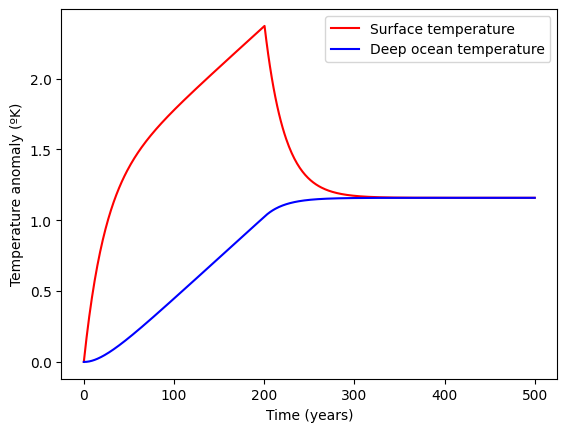

In [160]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of $T$ and $\theta$ to the forcing by defining characteristic timescales from the box model equations?

The surface temperature sees a rapid increase in temperature within the first 200 years, then experiences a dip and gradual decline at the approximate temperature anomaly of 2.5K before plateauing at a constant temperature anomaly of 1K which is shared by the ocean as well. However, the ocean doesn't see a sharp increase, rather a steady/almost linear increase within the first 200 years before also plateauing at a constant temperature anomaly of 1K. Which aligns with the different characteristic timescales described in the box model. Also, according to the box model, the surface temperature is directly exposed to the forcing net surface heat flux, which accounts for the faster heating of the surface and the rapid increase in the plot. In addition, the Cd is much higher than the Cs, also Cd & Cs are inversely proportional to the change in timescale, so the higher the heat capacity, in this case with the ocean, the slower the adjustment, which is seen in the steady rise of the deep ocean temperature in the plot. However, after some time, they both reach an equilibrum state.

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

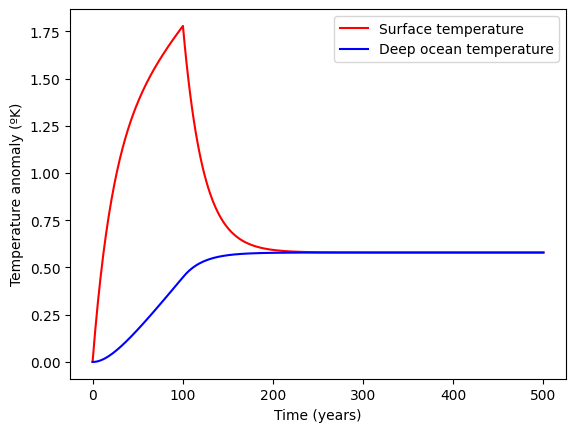

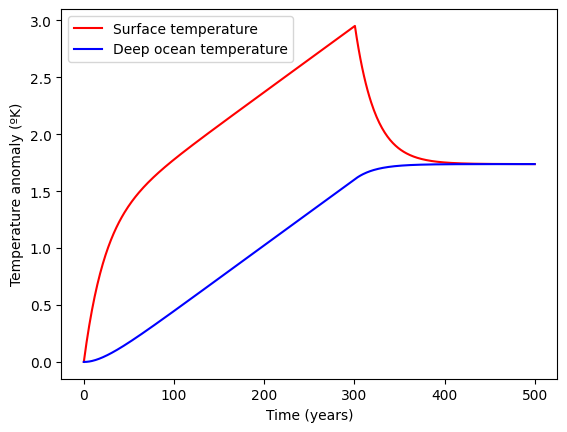

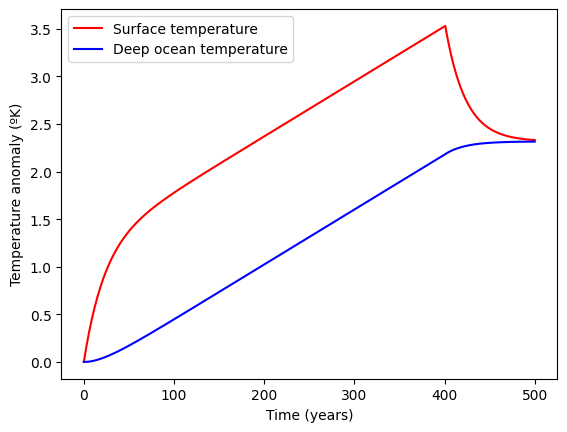

In [178]:

def F(t):
    return 1 if t < 100 else 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma*(T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + dt * (gamma*(T[i] - theta[i])) / C_d

plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

def F(t):
    return 1 if t < 300 else 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma*(T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + dt * (gamma*(T[i] - theta[i])) / C_d

plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

def F(t):
    return 1 if t < 400 else 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma*(T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + dt * (gamma*(T[i] - theta[i])) / C_d

plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()


When F(t) = 100
There is a an almost parallel rise of T to the peak anomaly temperature of 1.75K @ 100 years, before it dips and gradually plateaus to a temperature of 0.5K from 200 years onward, while Theta just has a gradual rise to 0.5K @ 100 years before plateauing as well at a constant temperature. 
When F(t) = 300
There is a sharp increase of T to a temperature anomaly of 1K, but then a linear increase similar to that of the Theta but at a higher temperaure anomaly, it then dips at 3.0K @ 300 years before it reaches a constant value of about 1.6K @ 400 years. The Theta increases steadily before also reaching a constant 1.6k @ 300 years
When F(t) = 400
There is a sharp increase of T to a temperature anomaly of 1.4K, but then a linear increase similar to that of the Theta but at a higher temperaure anomaly, it then dips at 3.5K @ 400 years before it reaches a constant value of about 2.25K @ 450 years. The Theta increases steadily before also reaching a constant 2.25k @ 400 years

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [162]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [163]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [164]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [165]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [166]:
# Defining parameters
kappa = 0.005  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [167]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.10 seconds


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

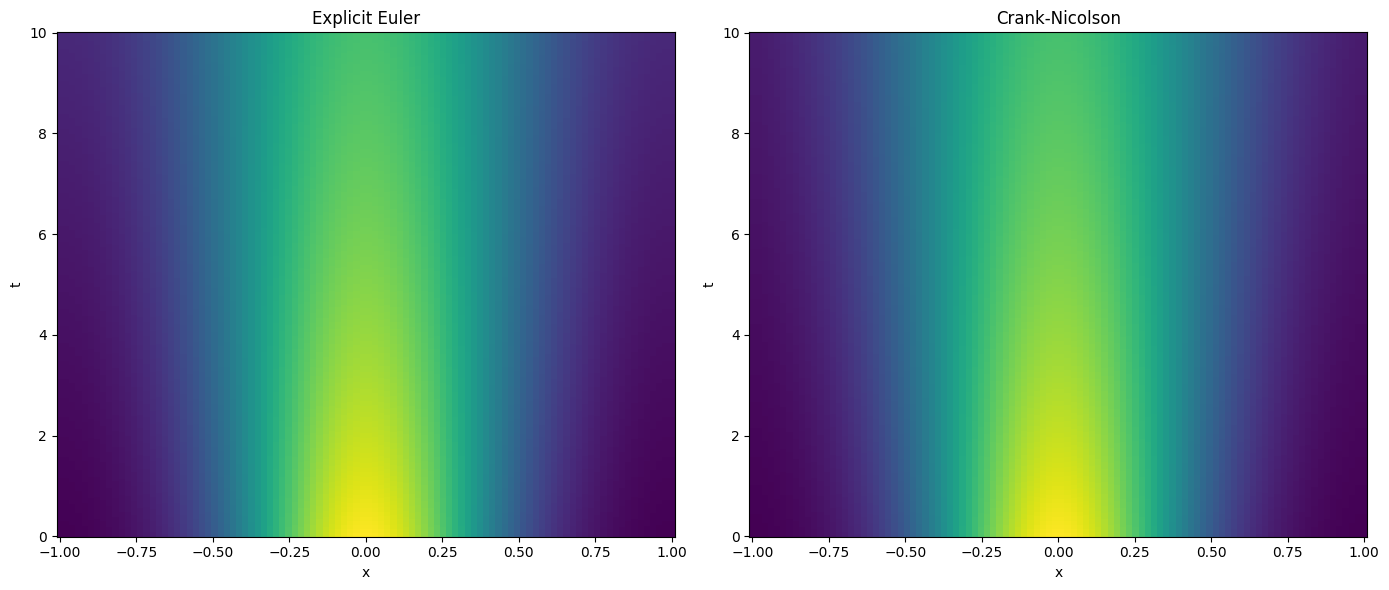

In [168]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

Increasing the diffusivity, from 0.001 to 0.1 causes the explicit euler (EE) method to fail due to instability. However, for the crank-nicholson (CN), the graph continues to spread out and remains stable within the range of 0-1. The time of execution of the EE is also much shorter than the CN method because it has no additional steps to compute.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

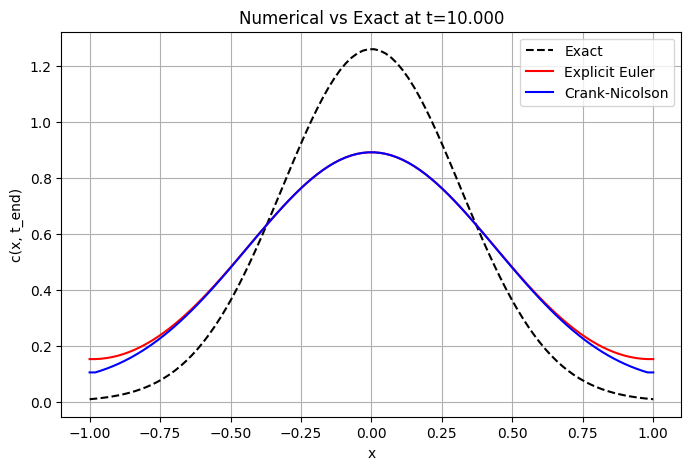

In [169]:
import numpy as np 
import matplotlib.pyplot as plt 

# final time index and value 
tf = t[-1] 

# exact solution on unbounded domain at time tf (same formula as set_ics but with t=tf) 

c_exact = (4*np.pi*kappa*tf)**(-0.5) * np.exp(-x**2 / (4*kappa*tf)) 

# If tf is zero (shouldn't be here), fall back to the initial condition time used earlier 
if np.isclose(tf, 0.0): c_exact = set_ics(x, kappa, 10) 

# numerical solutions at final time 
c_EE_final = c_EE[:, -1] 
c_CN_final = c_CN[:, -1] 


#Plotting 

plt.figure(figsize=(8,5)) 
plt.plot(x, c_exact, 'k--', label='Exact') 
plt.plot(x, c_EE_final, 'r-', label='Explicit Euler') 
plt.plot(x, c_CN_final, 'b-', label='Crank-Nicolson') 
plt.xlabel('x') 
plt.ylabel('c(x, t_end)') 
plt.title(f'Numerical vs Exact at t={tf:.3f}') 
plt.legend() 
plt.grid(True) 
plt.show()






The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

this is ee: [[0.01038216 0.01065769 0.0109058  ... 0.15177983 0.15193101 0.15208218]
 [0.01038216 0.01065769 0.0109058  ... 0.15177983 0.15193101 0.15208218]
 [0.01262889 0.01268085 0.0127612  ... 0.15301264 0.15316363 0.1533146 ]
 ...
 [0.01262889 0.01268085 0.0127612  ... 0.15301264 0.15316363 0.1533146 ]
 [0.01038216 0.01065769 0.0109058  ... 0.15177983 0.15193101 0.15208218]
 [0.01038216 0.01065769 0.0109058  ... 0.15177983 0.15193101 0.15208218]]
this is cn: [[0.01038216 0.01056947 0.01074242 ... 0.10423205 0.10431866 0.10440523]
 [0.01038216 0.01056947 0.01074242 ... 0.10423205 0.10431866 0.10440523]
 [0.01262889 0.0126887  0.01276182 ... 0.11067018 0.11076116 0.11085209]
 ...
 [0.01262889 0.0126887  0.01276182 ... 0.11067018 0.11076116 0.11085209]
 [0.01038216 0.01056947 0.01074242 ... 0.10423205 0.10431866 0.10440523]
 [0.01038216 0.01056947 0.01074242 ... 0.10423205 0.10431866 0.10440523]]


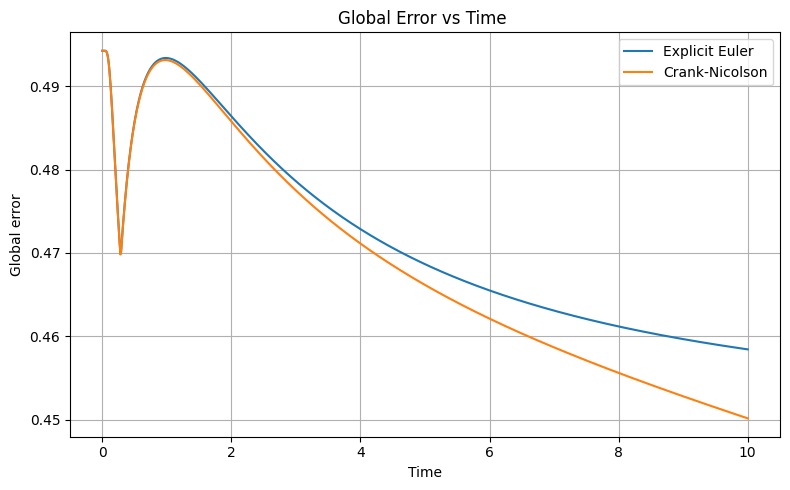

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Position Parameters
x_start = -10
x_end = 10
nx = 100

#timestepping parameters
t_start = 0  # start time
t_end = 10  # end time
nt = 1000  # number of timesteps

t = np.linspace(t_start, t_end, nt)  # Create a vector of times
x = np.linspace(x_start, x_end, nx)  # Create a vector for x

dx = x[1] - x[0]   
dt = t[1] - t[0] 

EE_Normal_Error = np.zeros((nx,nt))
CN_Normal_Error = np.zeros((nx,nt))
EE_Local_Error = np.zeros((nx,nt))
CN_Local_Error = np.zeros((nx,nt))
c_EE_final = np.zeros((nx, nt))
c_CN_final = np.zeros((nx, nt))
EE_Global_Error = np.zeros(nt)
CN_Global_Error = np.zeros(nt)


def exact_solution(x, t, kappa):
    x = x[:, np.newaxis]  
    t = t[np.newaxis, :]
    t = np.where(t == 0, 1e-10, t)
    return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

c_exact = exact_solution(x, t, kappa)


for (j) in range((nt)):
    for (i) in range(nx-1):
        EE_Normal_Error[i,j] = np.abs(c_exact[i,j] - c_EE[i,j])
        CN_Normal_Error[i,j] = np.abs (c_exact[i,j] - c_CN[i,j])
        EE_Local_Error[i] = np.abs(EE_Normal_Error[i+1]) - np.abs(EE_Normal_Error[i])
        CN_Local_Error[i] = np.abs (CN_Normal_Error[i+1]) - np.abs(CN_Normal_Error[i])
    EE_Global_Error[j] = np.mean(EE_Normal_Error[:,j])  
    CN_Global_Error[j] = np.mean(CN_Normal_Error[:,j])
     

print (f"this is ee: {c_EE}")
print (f"this is cn: {c_CN}")

#print (f"EE error is: {EE_Global_Error}")
#print (f"CN error is: {CN_Global_Error}")

# Plotting global error vs dt
plt.figure(figsize=(8, 5))
plt.plot(t, EE_Global_Error, label='Explicit Euler')
plt.plot(t, CN_Global_Error, label='Crank-Nicolson')
plt.xlabel('Time')
plt.ylabel('Global error')
plt.title('Global Error vs Time ')
plt.grid(True, which='both', linestyle='-')
plt.legend()
plt.tight_layout()
plt.show()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

In [ ]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

SyntaxError: invalid syntax (2790930227.py, line 1)

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)